In [1]:
import pandas as pd
import numpy as np
from time import time

# Processors
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from feature_engine.selection import DropDuplicateFeatures, DropConstantFeatures, DropCorrelatedFeatures, SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin

# Classifiers
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.decomposition import PCA

#Visualizers
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss
from sklearn.metrics import zero_one_loss
from sklearn.metrics import matthews_corrcoef
import shap

In [2]:
df_train = pd.read_csv('kdd_train.csv')

In [3]:
df_train.shape

(125973, 42)

## EDA

In [4]:
# Check data types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [5]:
# Check null values
df_train.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [6]:
# Check duplicated records
df_train.duplicated().sum()

0

In [7]:
# Binary variables
is_binary_col = df_train.apply(lambda x: set(x.unique()).issubset({0, 1}))
binary_columns = [col for col, is_binary in is_binary_col.items() if is_binary]
print("Binary variables:", binary_columns)

Binary variables: ['land', 'logged_in', 'root_shell', 'num_outbound_cmds', 'is_host_login', 'is_guest_login']


In [8]:
# Quantitative variables
def getRanges(data):
    ranges={}
    for c in data.columns:
        if c not in binary_columns and (data[c].dtype=='int64' or data[c].dtype=='float64'):
            ranges[c]=(data[c].max()-data[c].min())
            print(f'{c} : range = {ranges[c]}, cardinality = {data[c].nunique()} \n')
    return ranges

continuous_v = getRanges(df_train)
print('# continuous variables: ', len(continuous_v))

duration : range = 42908, cardinality = 2981 

src_bytes : range = 1379963888, cardinality = 3341 

dst_bytes : range = 1309937401, cardinality = 9326 

wrong_fragment : range = 3, cardinality = 3 

urgent : range = 3, cardinality = 4 

hot : range = 77, cardinality = 28 

num_failed_logins : range = 5, cardinality = 6 

num_compromised : range = 7479, cardinality = 88 

su_attempted : range = 2, cardinality = 3 

num_root : range = 7468, cardinality = 82 

num_file_creations : range = 43, cardinality = 35 

num_shells : range = 2, cardinality = 3 

num_access_files : range = 9, cardinality = 10 

count : range = 511, cardinality = 512 

srv_count : range = 511, cardinality = 509 

serror_rate : range = 1.0, cardinality = 89 

srv_serror_rate : range = 1.0, cardinality = 86 

rerror_rate : range = 1.0, cardinality = 82 

srv_rerror_rate : range = 1.0, cardinality = 62 

same_srv_rate : range = 1.0, cardinality = 101 

diff_srv_rate : range = 1.0, cardinality = 95 

srv_diff_host_rate :

In [9]:
# invalid value in su_attempted
# according to the feature description, su_attempted should be a binary variable
# there are 59 records with a value of 2
# these records all belong to 'normal' class
# since the records are only a few and 'normal' is the majority class, drop them
print('# occurrences of su_attempted')
print(df_train['su_attempted'].value_counts(), '\n')
print('class distribution of invalid records')
for i, v in df_train[df_train['su_attempted'] == 2]['labels'].value_counts().items():
    print('class:', i, 'count:', v)

df_train = df_train[df_train['su_attempted'] != 2]

# occurrences of su_attempted
su_attempted
0    125893
2        59
1        21
Name: count, dtype: int64 

class distribution of invalid records
class: normal count: 59


In [10]:
# Categorical variables
def getCategoricalValues(data):
    categoricalVals={}
    for c in data.columns:
        if data[c].dtype=='object':
            categoricalVals[c]=data[c].unique()
            print(f'{c} : {sorted(list(data[c].unique()))} \n count = {len(list(data[c].unique()))} \n')
    return categoricalVals

categorical_v = getCategoricalValues(df_train)
print('# categorical variables: ', len(categorical_v))

protocol_type : ['icmp', 'tcp', 'udp'] 
 count = 3 

service : ['IRC', 'X11', 'Z39_50', 'aol', 'auth', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp', 'ftp_data', 'gopher', 'harvest', 'hostnames', 'http', 'http_2784', 'http_443', 'http_8001', 'imap4', 'iso_tsap', 'klogin', 'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns', 'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u', 'other', 'pm_dump', 'pop_2', 'pop_3', 'printer', 'private', 'red_i', 'remote_job', 'rje', 'shell', 'smtp', 'sql_net', 'ssh', 'sunrpc', 'supdup', 'systat', 'telnet', 'tftp_u', 'tim_i', 'time', 'urh_i', 'urp_i', 'uucp', 'uucp_path', 'vmnet', 'whois'] 
 count = 70 

flag : ['OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH'] 
 count = 11 

labels : ['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 'loadmodule', 'multihop', 'neptune', 'nmap', 'nor

In [12]:
# categorical_f = list(set(categorical_v.keys()) - set(['labels']))
# df_train[categorical_f] = df_train[categorical_f].astype('category')

C:\Users\User\AppData\Local\Temp\ipykernel_33940\2985135278.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="labels",


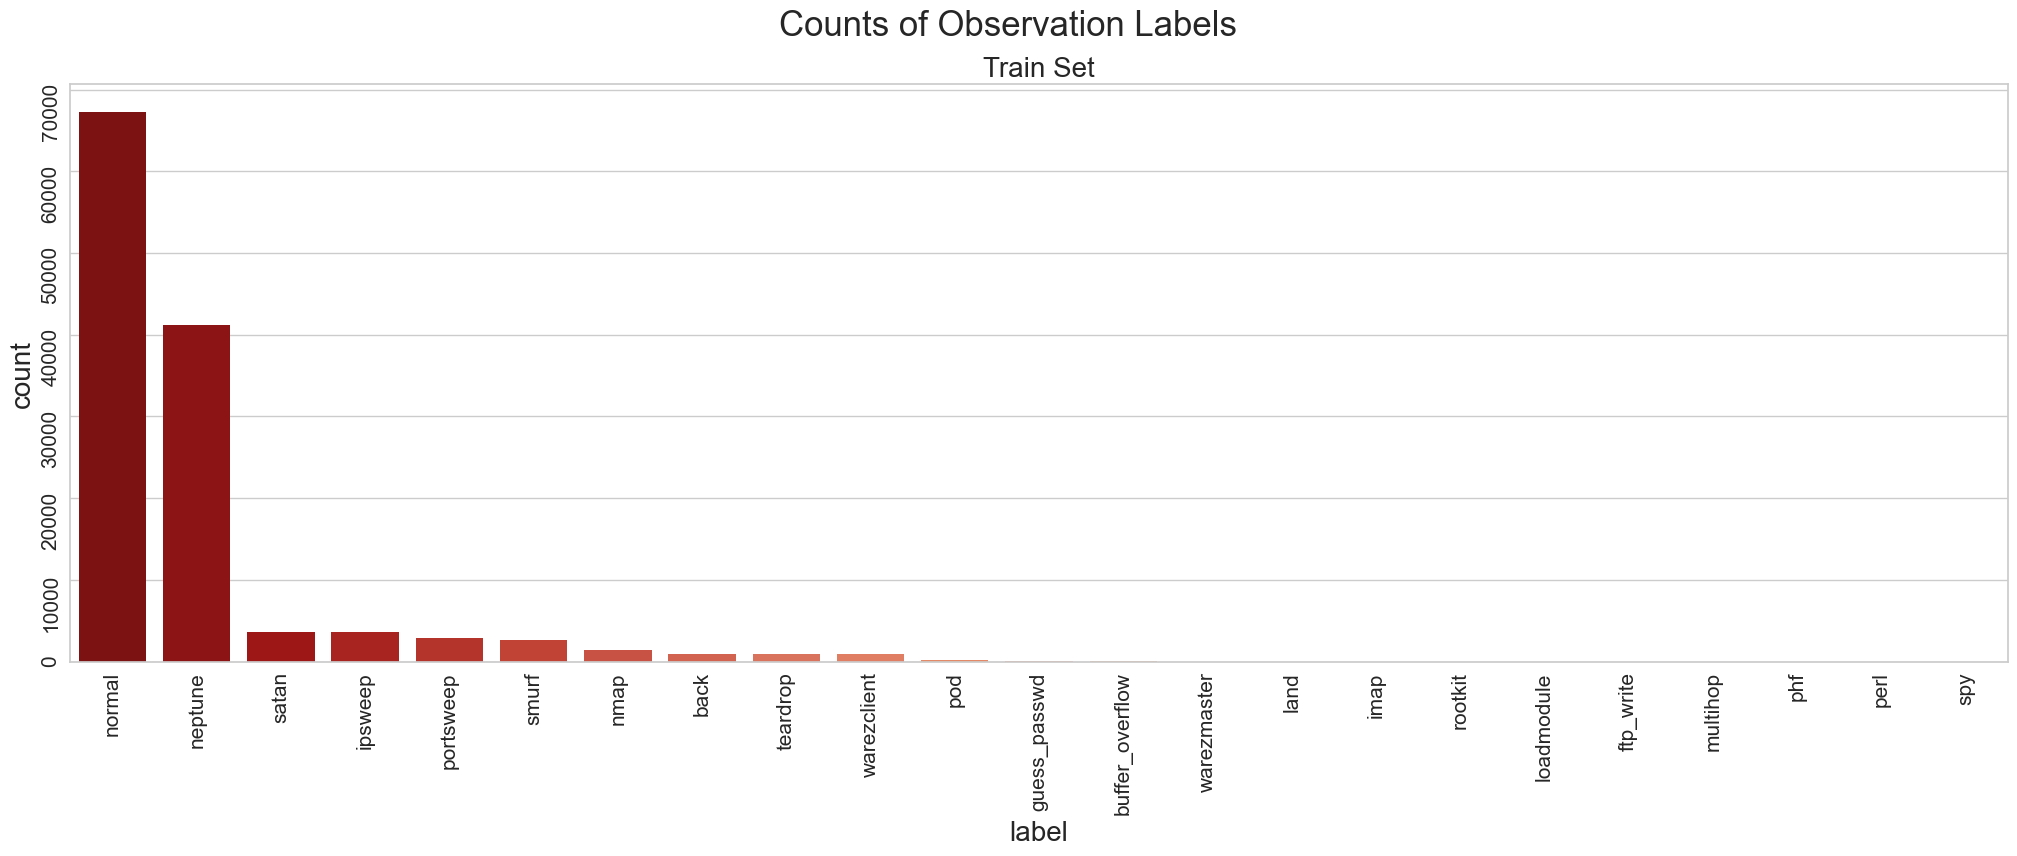

In [11]:
# Distribution of target variable
fig, ax = plt.subplots(figsize=(25, 7.5), dpi=100)

fig.suptitle(f'Counts of Observation Labels', fontsize=25)

sns.countplot(x="labels", 
              palette="OrRd_r", 
              data=df_train, 
              order=df_train['labels'].value_counts().index,
              ax=ax,
              linewidth=2)

ax.set_title('Train Set', fontsize=20)
ax.set_xlabel('label', fontsize=20)
ax.set_ylabel('count', fontsize=20)
ax.tick_params(labelrotation=90, labelsize=15)

plt.show()

## Feature Engineering

### Target Variable

In [12]:
# There are 23 kinds of labels
# Group them into 4 groups based on attack type
attack_dict = {
    'normal': 'normal',
    
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',    
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}
df_train['labels5'] = df_train['labels'].replace(attack_dict)

In [13]:
# Also can group into 2 groups (whether attacked or not)
df_train.loc[df_train['labels'] != 'normal', 'labels2'] = 'attack'
df_train.loc[df_train['labels'] == 'normal', 'labels2'] = 'normal'

C:\Users\User\AppData\Local\Temp\ipykernel_33940\32940383.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="labels5",
C:\Users\User\AppData\Local\Temp\ipykernel_33940\32940383.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="labels2",


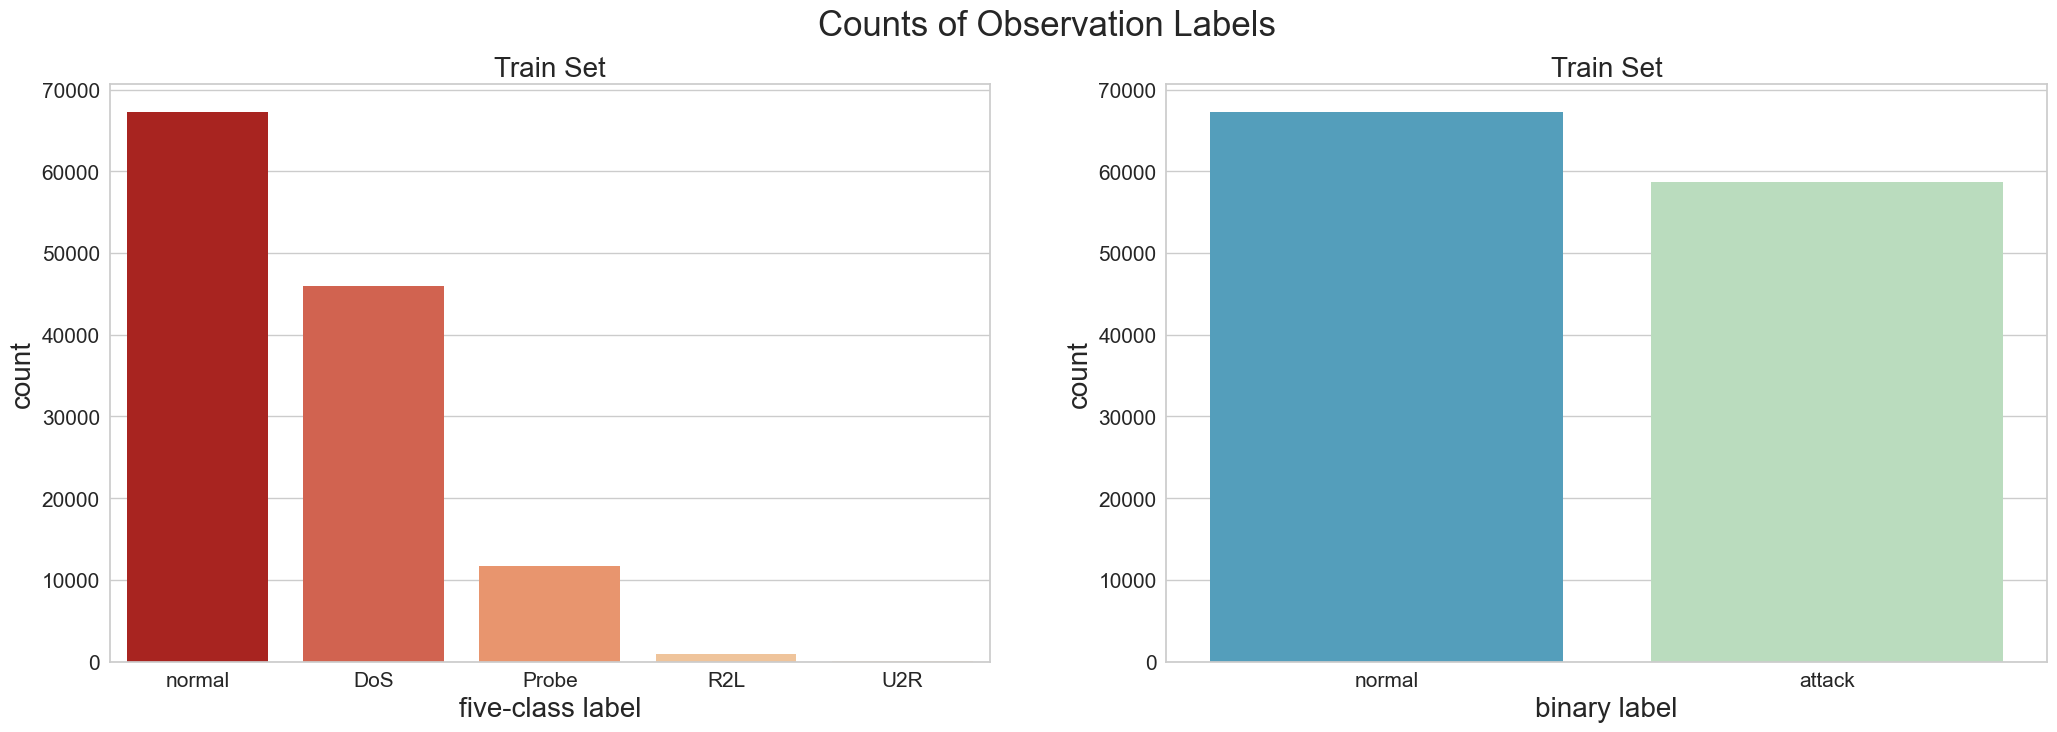

In [14]:
# Distribution after grouping
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(25, 7.5), dpi=100)

fig.suptitle(f'Counts of Observation Labels', fontsize=25)

sns.countplot(x="labels5", 
            palette="OrRd_r", 
            data=df_train, 
            order=df_train['labels5'].value_counts().index,
            ax=ax1)

ax1.set_title('Train Set', fontsize=20)
ax1.set_xlabel('five-class label', fontsize=20)
ax1.set_ylabel('count', fontsize=20)
ax1.tick_params(labelsize=15)

sns.countplot(x="labels2", 
            palette="GnBu_r", 
            data=df_train, 
            order=df_train['labels2'].value_counts().index,
            ax=ax2)

ax2.set_title('Train Set', fontsize=20)
ax2.set_xlabel('binary label', fontsize=20)
ax2.set_ylabel('count', fontsize=20)
ax2.tick_params(labelsize=15)

plt.show()

In [15]:
# Encode target variable into numerical values (0 ~ n-1)
from sklearn.preprocessing import LabelEncoder

le2 = LabelEncoder()
df_train['labels2'] = le2.fit_transform(df_train['labels2'])
print('labels2: ', dict(zip(le2.classes_, le2.transform(le2.classes_))))

le5 = LabelEncoder()
df_train['labels5'] = le5.fit_transform(df_train['labels5'])
print('labels5: ', dict(zip(le5.classes_, le5.transform(le5.classes_))))

labels2:  {'attack': 0, 'normal': 1}
labels5:  {'DoS': 0, 'Probe': 1, 'R2L': 2, 'U2R': 3, 'normal': 4}


### Independent Variable

In [16]:
# Split data
X = df_train.drop(columns=['labels', 'labels2', 'labels5'])
y = df_train[['labels2', 'labels5']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

C:\Users\User\AppData\Local\Temp\ipykernel_33940\1289445338.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=X_train, y='service', order=service_counts.index, palette="viridis")


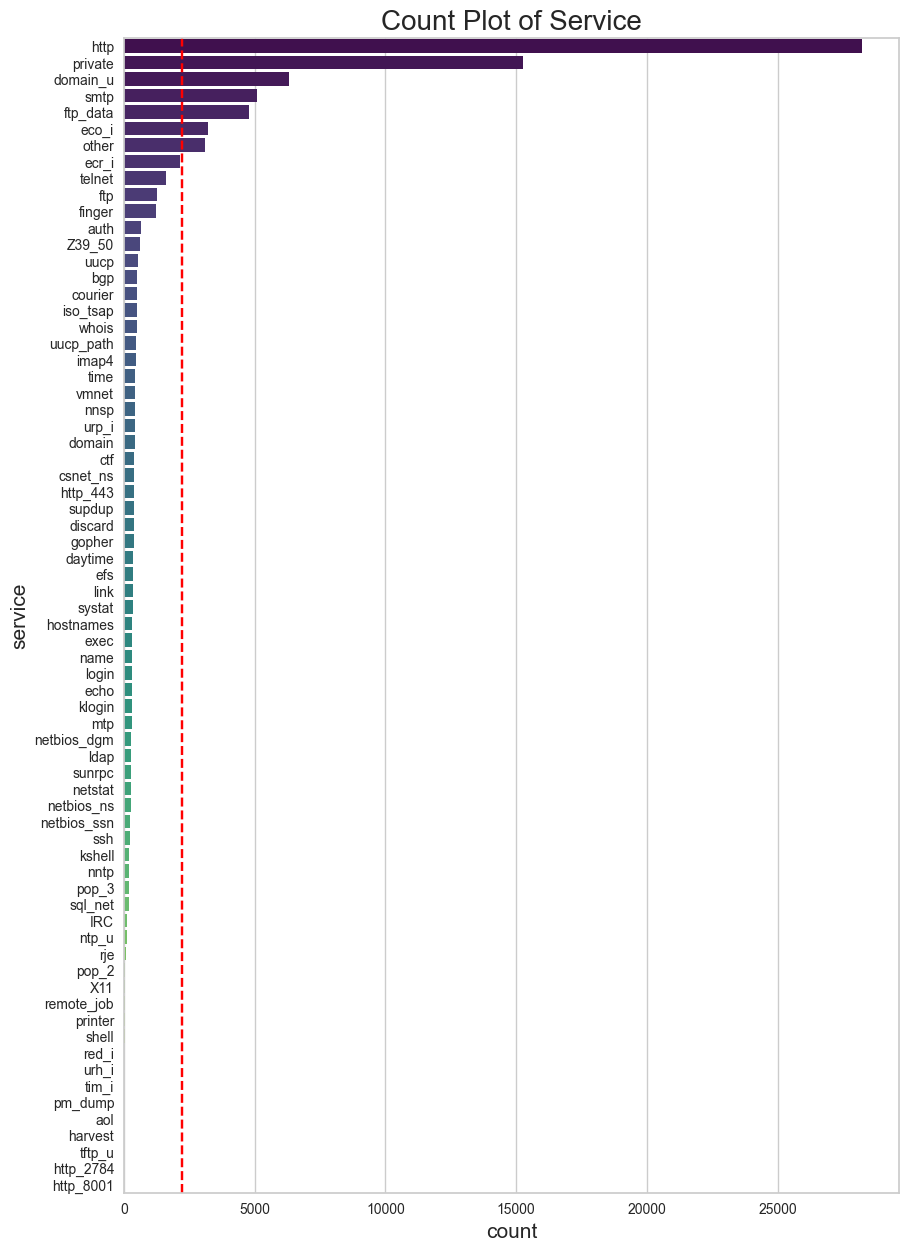

In [17]:
# Distribution of 'service'
plt.figure(figsize=(10, 15))
service_counts = X_train['service'].value_counts().sort_values(ascending=False)
ax = sns.countplot(data=X_train, y='service', order=service_counts.index, palette="viridis")
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_ylabel('service', fontsize=15)
ax.set_xlabel('count', fontsize=15)
plt.title('Count Plot of Service', fontsize=20)
x_position = X_train.shape[0] * 0.025 # 2.5% boundary
ax.axvline(x_position, color='red', linestyle='--')
plt.show()

In [18]:
# Wrap rare values of 'service'
class RareLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, threshold=0.01, replace_with='rare'):
        self.columns = columns
        self.threshold = threshold
        self.replace_with = replace_with
        self.rare_categories = {}

    def fit(self, X, y=None):
        if self.columns is None:
            self.columns = X.select_dtypes(include=['object', 'category']).columns

        for col in self.columns:
            frequencies = X[col].value_counts(normalize=True)
            self.rare_categories[col] = frequencies[frequencies < self.threshold].index.tolist()
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for col in self.columns:
            X_encoded[col] = X_encoded[col].apply(lambda x: self.replace_with if x in self.rare_categories[col] else x)
        return X_encoded
    
rare_encoder = RareLabelEncoder(columns=['service'])
X_train = rare_encoder.fit_transform(X_train)
X_test = rare_encoder.transform(X_test)

In [19]:
# Scale numeric features
cols_to_scale = list(continuous_v.keys())
cols_to_scale.remove('su_attempted')

scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])


## Feature Selection


**categorical:** protocol_type, service, flag

**binary:** is_guest_login, is_host_logi, root_shell, logged_in, land, su_attempted

**continuous and discrete**: the rest


### Basic

<Axes: >

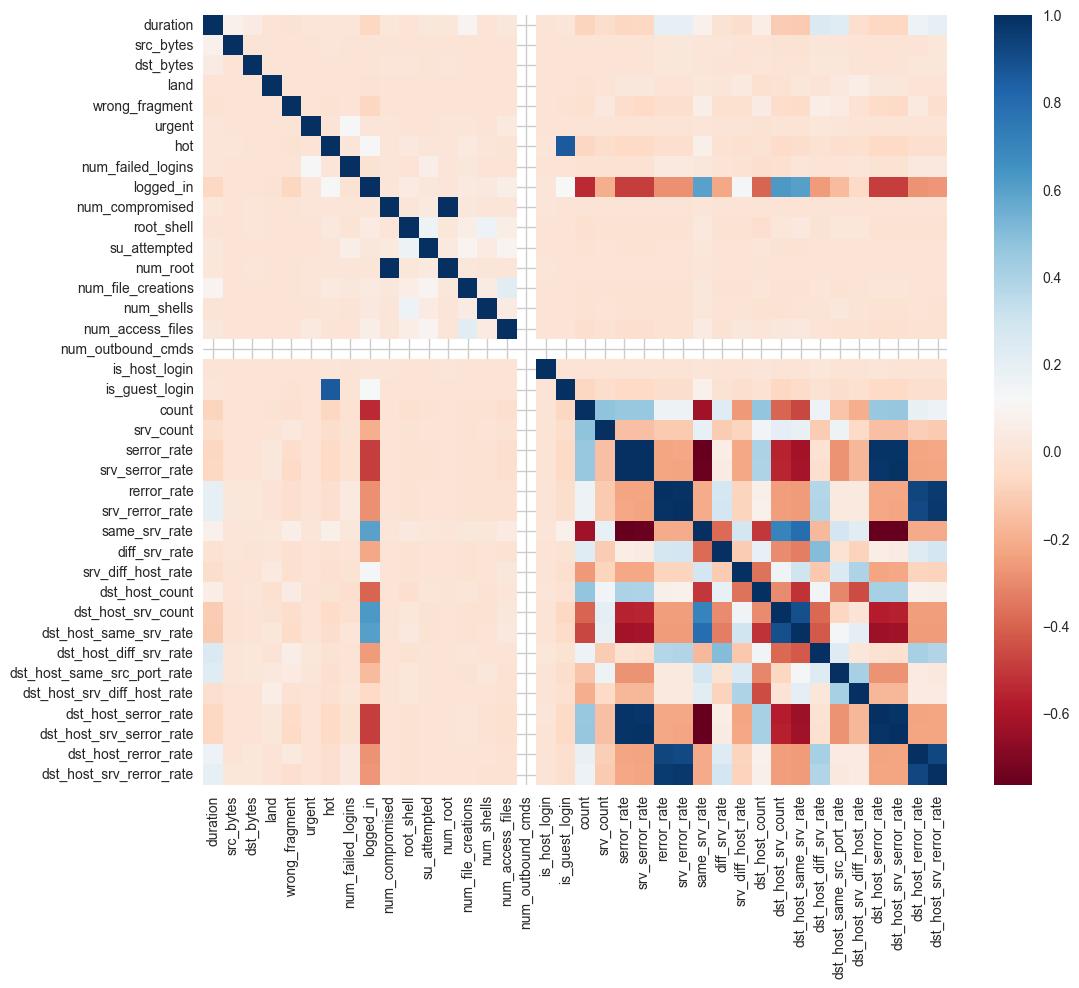

In [21]:
# Corrrelation heatmap
#corrmat = X_train.corr()
corrmat = X_train.select_dtypes(include='number').corr()
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.heatmap(corrmat, cmap='RdBu')

In [22]:
# Remove constant features
# only num_outbound_cmds is constant, though it is considered as a binary feature, cus all the values are 0
constant_v = [v for v in X_train.columns if X_train[v].nunique() == 1]
X_train.drop(labels=constant_v, axis=1, inplace=True)
X_test.drop(labels=constant_v, axis=1, inplace=True)

print(X_train.shape, X_test.shape)

(88139, 40) (37775, 40)


In [23]:
# Remove constant and quasi-constant features
# Remove duplicated features
# Remove correlated features
pipe = Pipeline([
    ('constant and quasi-constant', DropConstantFeatures(tol=0.998, variables=None)),
    ('duplicated', DropDuplicateFeatures()),
    ('correlated', SmartCorrelatedSelection(selection_method='variance'))
])

X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

print(X_train.shape, X_test.shape)
print('constant and quasi-constant: ', pipe.named_steps['constant and quasi-constant'].features_to_drop_)
print('duplicated: ', pipe.named_steps['duplicated'].features_to_drop_)
print('correlated: ', pipe.named_steps['correlated'].correlated_feature_sets_)

(88139, 24) (37775, 24)
constant and quasi-constant:  ['land', 'urgent', 'num_failed_logins', 'root_shell', 'su_attempted', 'num_shells', 'is_host_login']
duplicated:  set()
correlated:  [{'dst_host_srv_rerror_rate', 'rerror_rate', 'srv_rerror_rate', 'dst_host_rerror_rate'}, {'hot', 'is_guest_login'}, {'dst_host_serror_rate', 'serror_rate', 'srv_serror_rate', 'dst_host_srv_serror_rate'}, {'dst_host_srv_count', 'dst_host_same_srv_rate'}, {'num_root', 'num_compromised'}]


In [24]:
# Encode categorical features into numerical values (0 ~ n-1)
ordinal_encoder = OrdinalEncoder(
    encoding_method='arbitrary',
    variables=['protocol_type', 'service', 'flag']
)

X_train_encoded = ordinal_encoder.fit_transform(X_train)
X_test_encoded = ordinal_encoder.transform(X_test)

### PCA Visualization

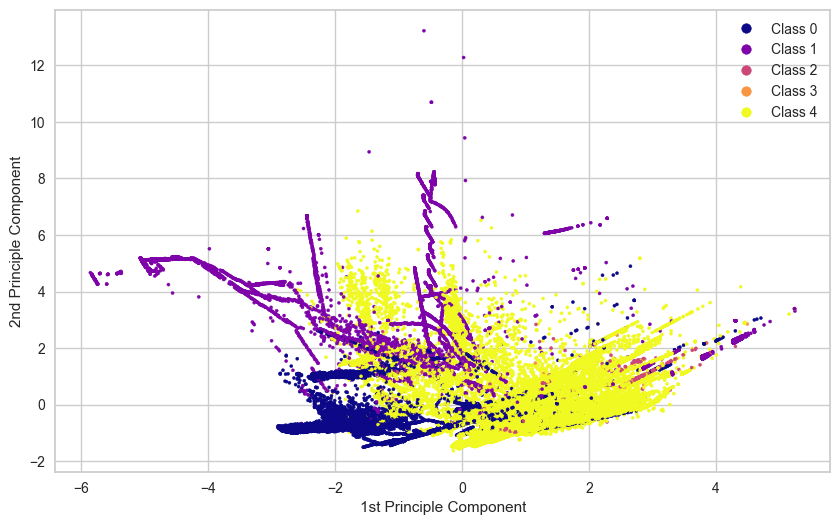

In [25]:
# The 2D PCA plot fails to show the separation among classes
pca = PCA(n_components=2)
result = pca.fit_transform(X_train.drop(columns=['protocol_type', 'service', 'flag']))

plt.figure(figsize=(10, 6))
scatter = plt.scatter(result[:, 0], result[:, 1], s=5, c=y_train['labels5'], cmap='plasma')
plt.xlabel('1st Principle Component')
plt.ylabel('2nd Principle Component')
plt.grid(True)

# Add class labels to the legend
legend_labels = ["Class " + str(label) for label in set(y_train['labels5'])]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)

plt.show()

<Axes: >

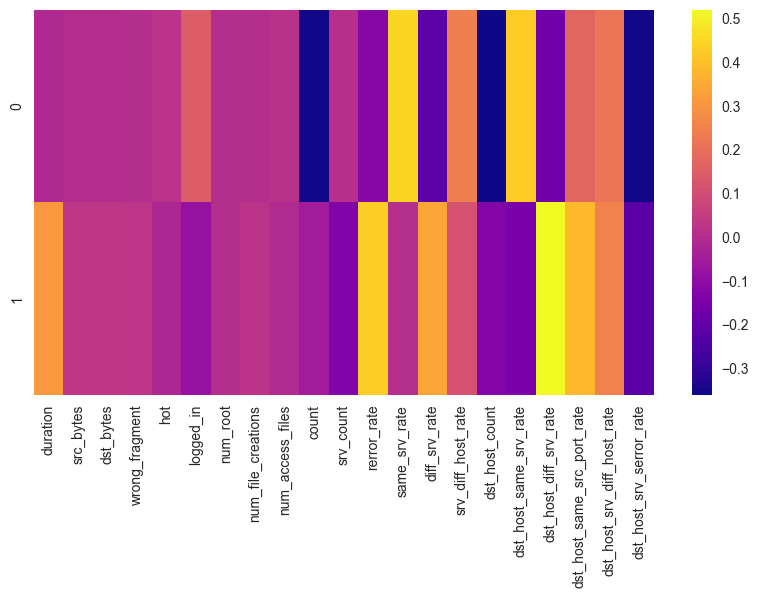

In [26]:
# Each row: PC
# Each column: feature
# Color: the contribution of a feature to a PC
plt.figure(figsize=(10, 5))
sns.heatmap(pd.DataFrame(pca.components_, columns=X_train.drop(columns=['protocol_type', 'service', 'flag']).columns), cmap='plasma')

### Feature Importance

In [27]:
model = DecisionTreeClassifier()
model.fit(X_train_encoded, y_train['labels5'])

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_encoded)

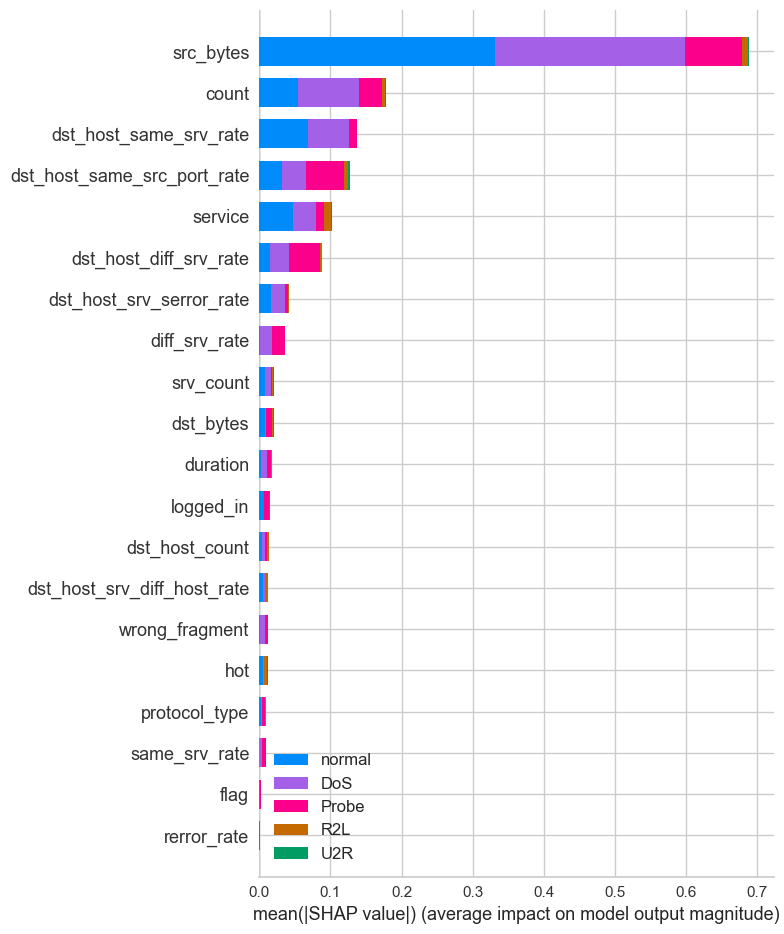

In [28]:
# The contribution of a feature to each class
classes = list(le5.classes_)
shap.summary_plot(shap_values, X_train_encoded, plot_type="bar", class_names= classes, feature_names = X_train.columns)

## Modeling

#### Traditional 5 Classes

In [29]:
# Confusion matrix
# Understand which classes are most easily confused
def CM_viz1():    
    def CM(model,classes,target):
        visualizer = ConfusionMatrix(model[1], classes=classes,percent=True)
        visualizer.fit(X_train_encoded, y_train[target])  # Fit the visualizer and the model
        visualizer.score(X_test_encoded, y_test[target])  # Evaluate the model on the test data 
        return visualizer.poof()  
    for model in models:
        print(model[0])
        ax = plt.subplot(1,1,1)
        CM(model,classes,target)

In [30]:
def CM_viz2():
    def CM(model, classes, target):
        # Train the model
        model = model[1]
        model.fit(X_train_encoded, y_train[target])

        # Make predictions
        y_pred = model.predict(X_test_encoded)

        # Filter out instances of the 5th class
        mask = (y_test[target] < 4) & (y_pred < 4)
        y_test_filtered = y_test[target][mask]
        y_pred_filtered = y_pred[mask]

        # Compute confusion matrix for the first 4 classes
        cm = confusion_matrix(y_test_filtered, y_pred_filtered)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Convert to percentage

        # Plotting
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap='GnBu', xticklabels=classes[:4], yticklabels=classes[:4])
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title(f'{model.__class__.__name__} Confusion Matrix - 4 Classes')
        plt.show()

        # Compute metrics for the first 4 classes
        accuracy = accuracy_score(y_test_filtered, y_pred_filtered)
        precision = precision_score(y_test_filtered, y_pred_filtered, average='weighted', zero_division=0)
        recall = recall_score(y_test_filtered, y_pred_filtered, average='weighted')
        f1 = f1_score(y_test_filtered, y_pred_filtered, average='weighted')
        c_k_s = cohen_kappa_score(y_test_filtered, y_pred_filtered)
        zero_met = zero_one_loss(y_test_filtered, y_pred_filtered)
        hl = hamming_loss(y_test_filtered, y_pred_filtered)
        mc = matthews_corrcoef(y_test_filtered, y_pred_filtered)

        print('Accuracy: {0:.3f}'.format(accuracy))
        print('Precision: {0:.3f}'.format(precision))
        print('Recall: {0:.3f}'.format(recall))
        print('F1 Score: {0:.3f}'.format(f1))
        print('Cohen\'s Kappa Score: {0:.3f}'.format(c_k_s))
        print('Zero-One Loss: {0:.3f}'.format(zero_met))
        print('Hamming Loss: {0:.3f}'.format(hl))
        print('Matthews Correlation Coefficient: {0:.3f}'.format(mc))

    for model in models:
        CM(model, classes, target)
        print()
        print("------------------------------------------------------")



In [31]:
# Function for aggregate metrics
def classifier_metrics():    
    def metrics(model,target):
        model.fit(X_train_encoded, y_train[target])
        y_pred = model.predict(X_test_encoded)
        
        try: 
            y_prob = model.predict_proba(X_test_encoded)
            log_metric = log_loss(y_test[target],y_prob)
        except:
            y_prob = "Not probablistic"
            log_metric = 0
        
        accuracy = accuracy_score(y_test[target], y_pred)
        precision = precision_score(y_test[target], y_pred, average='weighted')
        recall = recall_score(y_test[target], y_pred, average='weighted')
        f1 = f1_score(y_test[target], y_pred, average='weighted')

        c_k_s = cohen_kappa_score(y_test[target], y_pred)
        zero_met = zero_one_loss(y_test[target], y_pred)
        hl = hamming_loss(y_test[target], y_pred)
        mc = matthews_corrcoef(y_test[target], y_pred)
        
        print('Accuracy: {0:.3f}'.format(accuracy))
        print('Precision: {0:.3f}'.format(precision))
        print('Recall: {0:.3f}'.format(recall))
        print('F1 Score: {0:.3f}'.format(f1))
        print('Cohen\'s Kappa Score: {0:.3f}'.format(c_k_s))
        print('Log Loss: {0:.3f}'.format(log_metric))
        print('Zero-One Loss: {0:.3f}'.format(zero_met))
        print('Hamming Loss: {0:.3f}'.format(hl))
        print('Matthews Correlation Coefficient: {0:.3f}'.format(mc))
        
    for name in models:
        print(str(name[0]))
        metrics(name[1],target)
        print()
        print("------------------------------------------------------")


In [32]:
# Classification models
models = [
    ('Logistic Regression', LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(random_state=42))    
]

Logistic Regression


c:\Users\User\anaconda3\envs\aml_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


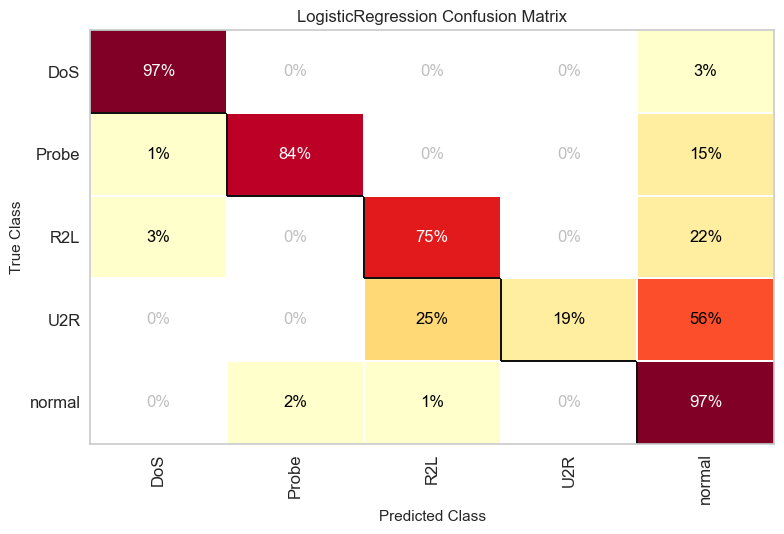

Decision Tree


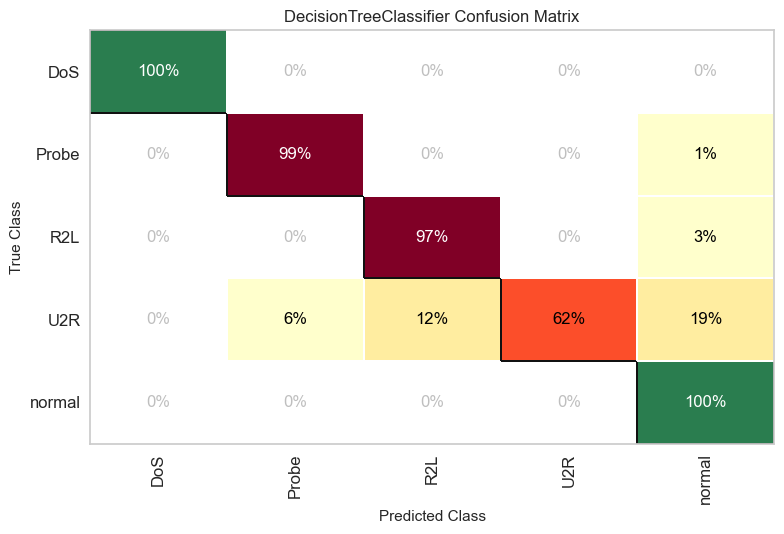

Random Forest


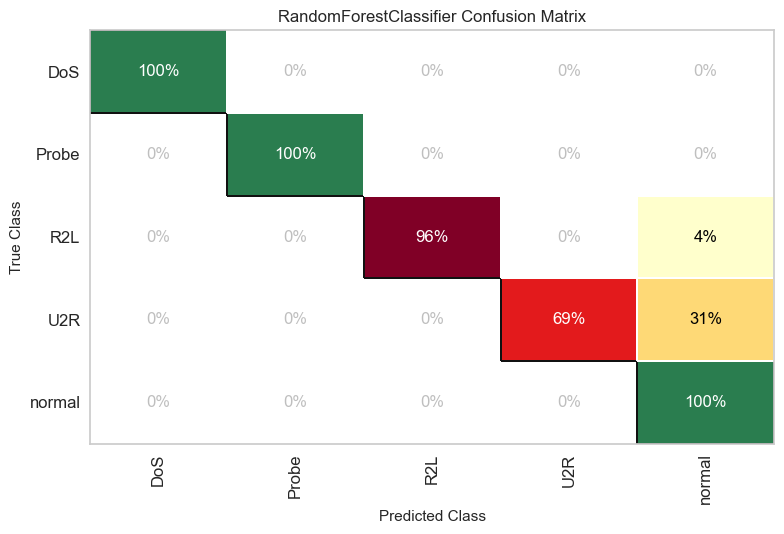

Logistic Regression


c:\Users\User\anaconda3\envs\aml_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.954
Precision: 0.955
Recall: 0.954
F1 Score: 0.954
Cohen's Kappa Score: 0.919
Log Loss: 0.148
Zero-One Loss: 0.046
Hamming Loss: 0.046
Matthews Correlation Coefficient: 0.920

------------------------------------------------------
Decision Tree
Accuracy: 0.998
Precision: 0.998
Recall: 0.998
F1 Score: 0.998
Cohen's Kappa Score: 0.996
Log Loss: 0.088
Zero-One Loss: 0.002
Hamming Loss: 0.002
Matthews Correlation Coefficient: 0.996

------------------------------------------------------
Random Forest
Accuracy: 0.999
Precision: 0.999
Recall: 0.999
F1 Score: 0.999
Cohen's Kappa Score: 0.998
Log Loss: 0.006
Zero-One Loss: 0.001
Hamming Loss: 0.001
Matthews Correlation Coefficient: 0.998

------------------------------------------------------


In [33]:
# Deploy visualization
target = 'labels5'
classes = list(le5.classes_)
visualization =[CM_viz1(), classifier_metrics()]

In [35]:
# Classification models
models = [
    ('Logistic Regression', LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(random_state=42))    
]

c:\Users\User\anaconda3\envs\aml_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


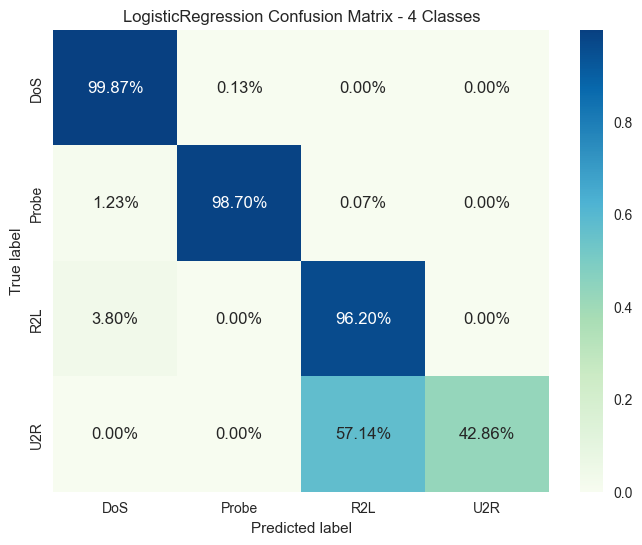

Accuracy: 0.996
Precision: 0.996
Recall: 0.996
F1 Score: 0.996
Cohen's Kappa Score: 0.987
Zero-One Loss: 0.004
Hamming Loss: 0.004
Matthews Correlation Coefficient: 0.987

------------------------------------------------------


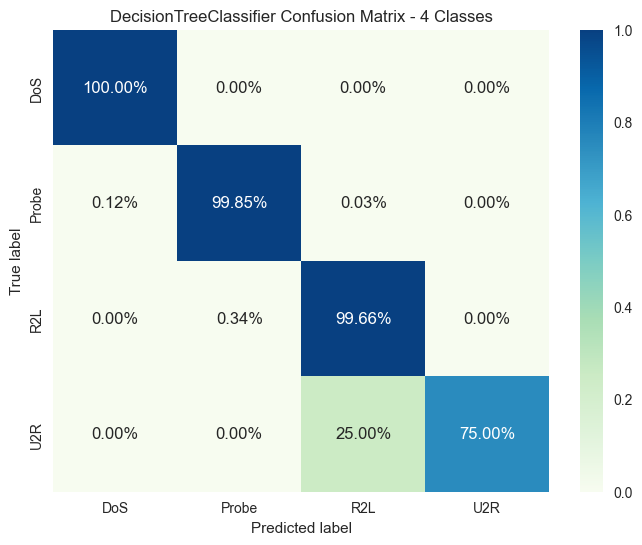

Accuracy: 0.999
Precision: 0.999
Recall: 0.999
F1 Score: 0.999
Cohen's Kappa Score: 0.999
Zero-One Loss: 0.001
Hamming Loss: 0.001
Matthews Correlation Coefficient: 0.999

------------------------------------------------------


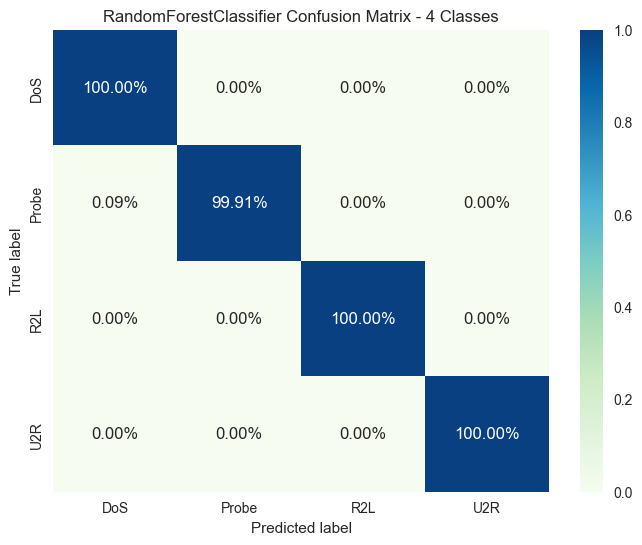

Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
Cohen's Kappa Score: 1.000
Zero-One Loss: 0.000
Hamming Loss: 0.000
Matthews Correlation Coefficient: 1.000

------------------------------------------------------


In [36]:
# Deploy visualization
target = 'labels5'
classes = list(le5.classes_)
visualization =[CM_viz2()]

### Weighted 5 Classes

In [37]:
models = [
    ('Balanced-weight Logistic Regression', LogisticRegression(multi_class='multinomial', solver='newton-cg', class_weight='balanced')),
    ('Balanced-weight Decision Tree', DecisionTreeClassifier(class_weight='balanced')),
    ('Balanced-weight Random Forest', RandomForestClassifier(class_weight='balanced', random_state=42))
]

Balanced-weight Logistic Regression


c:\Users\User\anaconda3\envs\aml_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


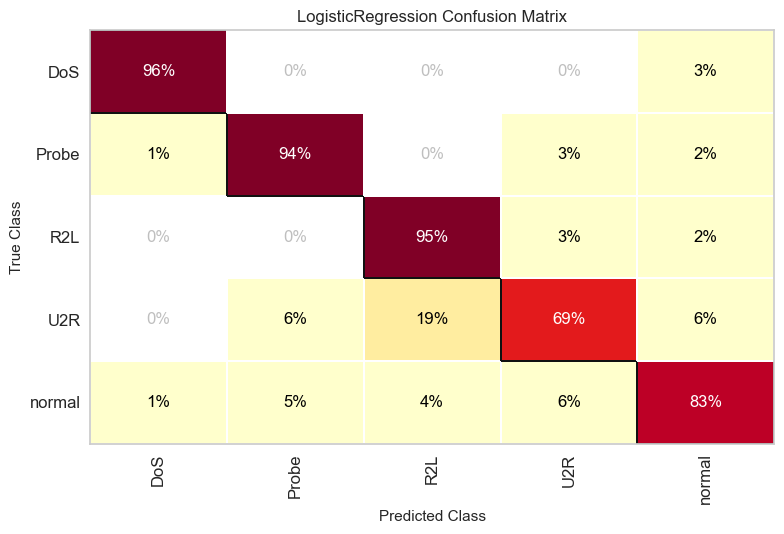

Balanced-weight Decision Tree


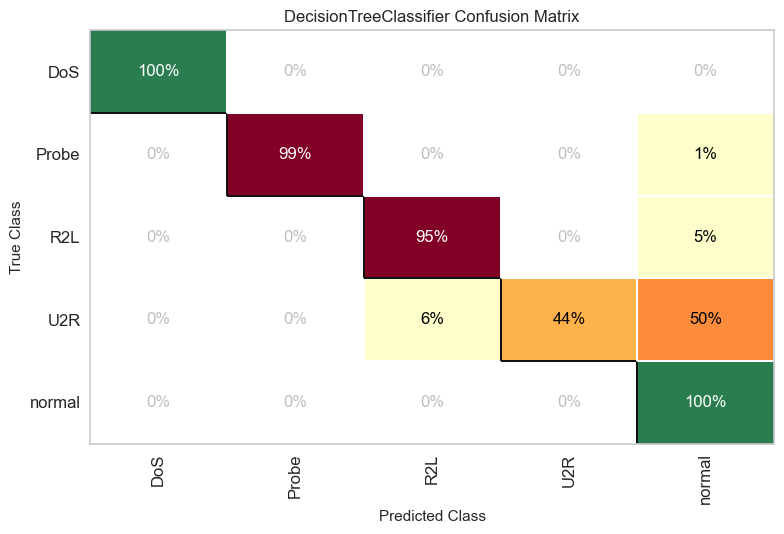

Balanced-weight Random Forest


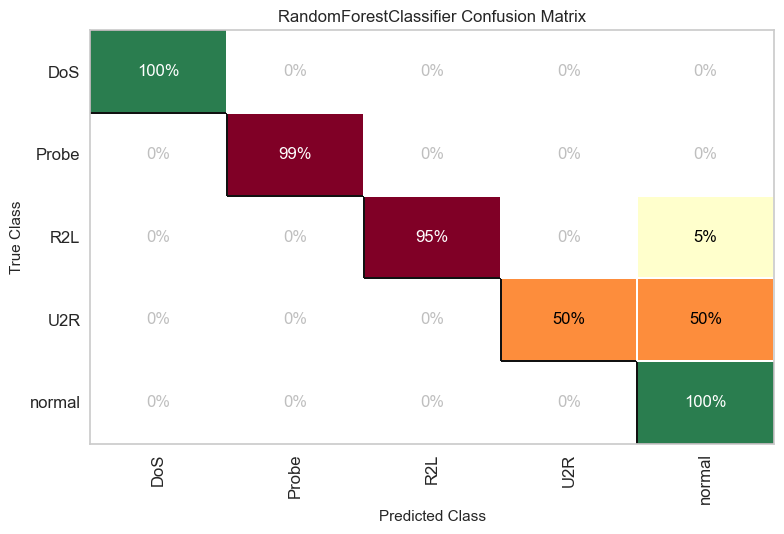

Balanced-weight Logistic Regression


c:\Users\User\anaconda3\envs\aml_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.892
Precision: 0.951
Recall: 0.892
F1 Score: 0.915
Cohen's Kappa Score: 0.824
Log Loss: 0.348
Zero-One Loss: 0.108
Hamming Loss: 0.108
Matthews Correlation Coefficient: 0.831

------------------------------------------------------
Balanced-weight Decision Tree
Accuracy: 0.997
Precision: 0.997
Recall: 0.997
F1 Score: 0.997
Cohen's Kappa Score: 0.995
Log Loss: 0.104
Zero-One Loss: 0.003
Hamming Loss: 0.003
Matthews Correlation Coefficient: 0.995

------------------------------------------------------
Balanced-weight Random Forest
Accuracy: 0.998
Precision: 0.998
Recall: 0.998
F1 Score: 0.998
Cohen's Kappa Score: 0.997
Log Loss: 0.006
Zero-One Loss: 0.002
Hamming Loss: 0.002
Matthews Correlation Coefficient: 0.997

------------------------------------------------------


In [38]:
# Deploy visualization
target = 'labels5'
classes = list(le5.classes_)
visualization =[CM_viz1(), classifier_metrics()]

### One-vs-Rest with 4 Subclasses

In [40]:
# Classification models
models = [
    ('Logistic Regression', LogisticRegression(solver = 'newton-cg')),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier())    
]

Logistic Regression


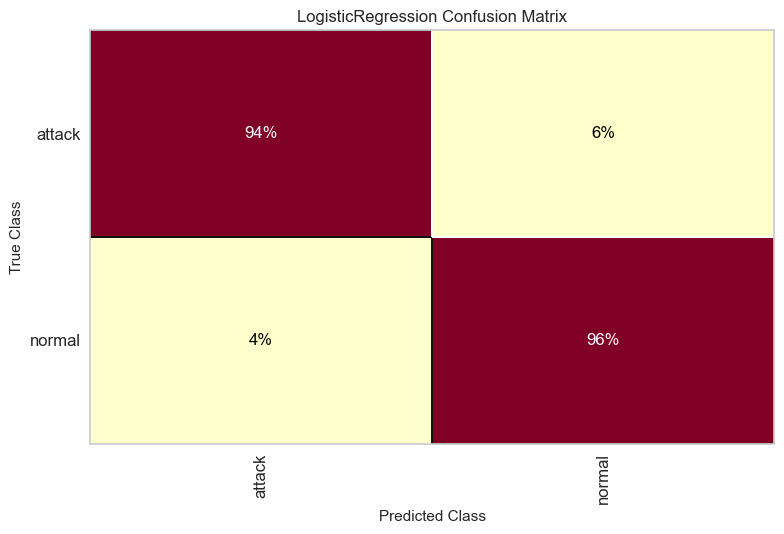

Decision Tree


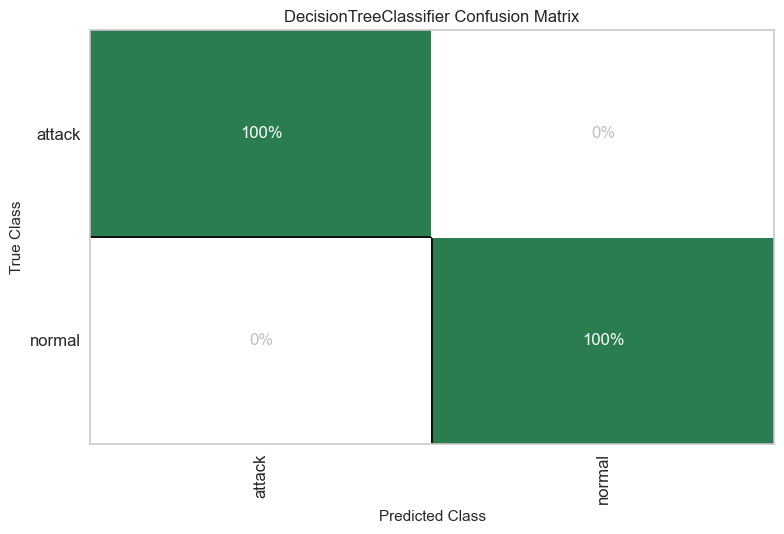

Random Forest


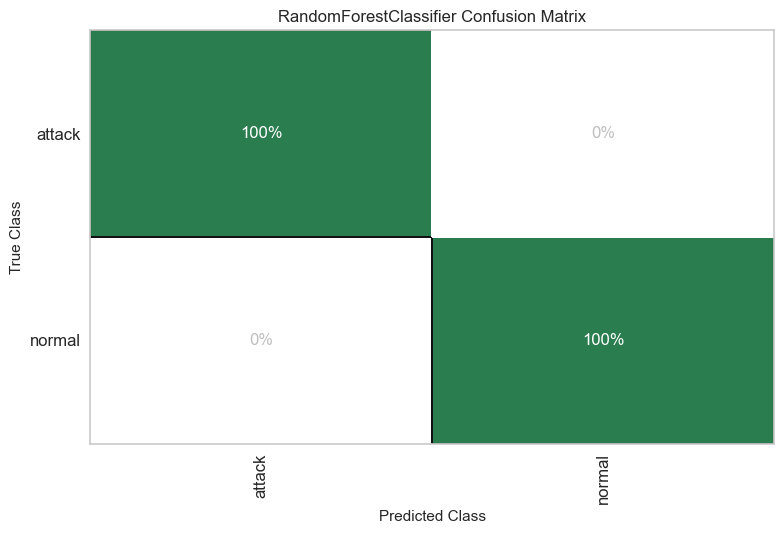

Logistic Regression
Accuracy: 0.953
Precision: 0.953
Recall: 0.953
F1 Score: 0.953
Cohen's Kappa Score: 0.905
Log Loss: 0.141
Zero-One Loss: 0.047
Hamming Loss: 0.047
Matthews Correlation Coefficient: 0.905

------------------------------------------------------
Decision Tree
Accuracy: 0.997
Precision: 0.997
Recall: 0.997
F1 Score: 0.997
Cohen's Kappa Score: 0.995
Log Loss: 0.091
Zero-One Loss: 0.003
Hamming Loss: 0.003
Matthews Correlation Coefficient: 0.995

------------------------------------------------------
Random Forest
Accuracy: 0.999
Precision: 0.999
Recall: 0.999
F1 Score: 0.999
Cohen's Kappa Score: 0.997
Log Loss: 0.005
Zero-One Loss: 0.001
Hamming Loss: 0.001
Matthews Correlation Coefficient: 0.997

------------------------------------------------------


In [41]:
# Deploy visualization
target = 'labels2'
classes = list(le2.classes_)
visualization =[CM_viz1(), classifier_metrics()]

##### Phase 1

In [42]:
# Random Forest performs the best, thus we select it as the model for further training 
rf1 = RandomForestClassifier()

# Train the Random Forest classifier
rf1.fit(X_train_encoded, y_train['labels2'])

# Make predictions on the test data
y_pred1 = rf1.predict(X_test_encoded)
print("Phase 1 Classification Report:")
print(classification_report(y_test['labels2'], y_pred1, target_names=le2.classes_))

Phase 1 Classification Report:
              precision    recall  f1-score   support

      attack       1.00      1.00      1.00     17617
      normal       1.00      1.00      1.00     20158

    accuracy                           1.00     37775
   macro avg       1.00      1.00      1.00     37775
weighted avg       1.00      1.00      1.00     37775



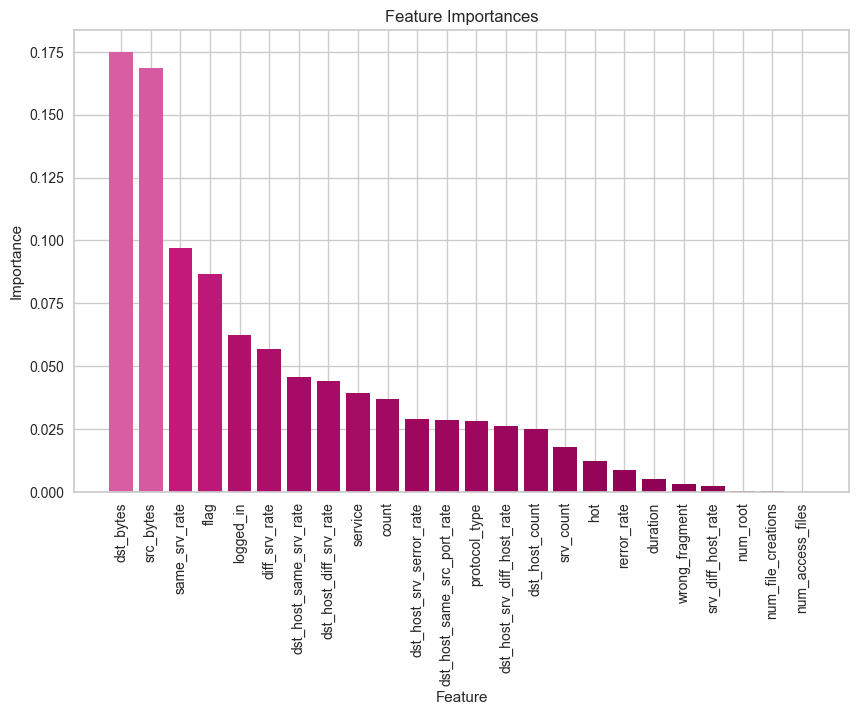

In [43]:
# Get feature importances
feature_importances = rf1.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
cmap = plt.get_cmap('PiYG')
plt.figure(figsize=(10, 6))
plt.bar(range(X_train_encoded.shape[1]), feature_importances[indices], align='center', color=cmap(feature_importances[indices]))
plt.xticks(range(X_train_encoded.shape[1]), X_train_encoded.columns[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

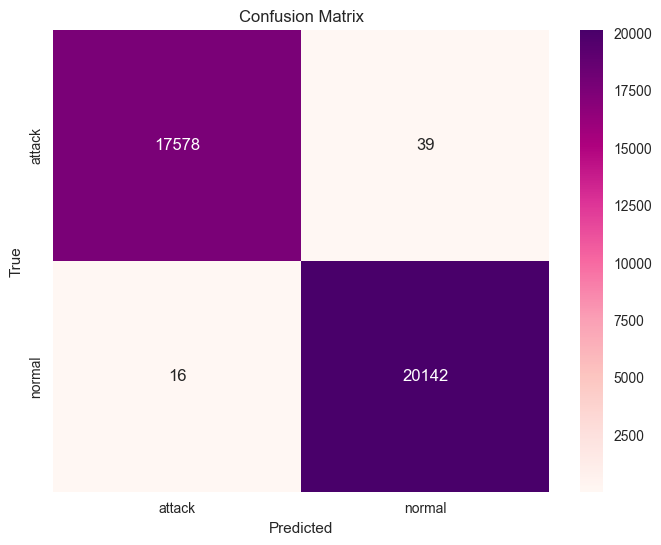

In [44]:
# Confusion matrix
cm1 = confusion_matrix(y_test['labels2'], y_pred1)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, cmap='RdPu', fmt='g', xticklabels=le2.classes_, yticklabels=le2.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Text(0.5, 1.0, 'Confusion Matrix with Percentages')

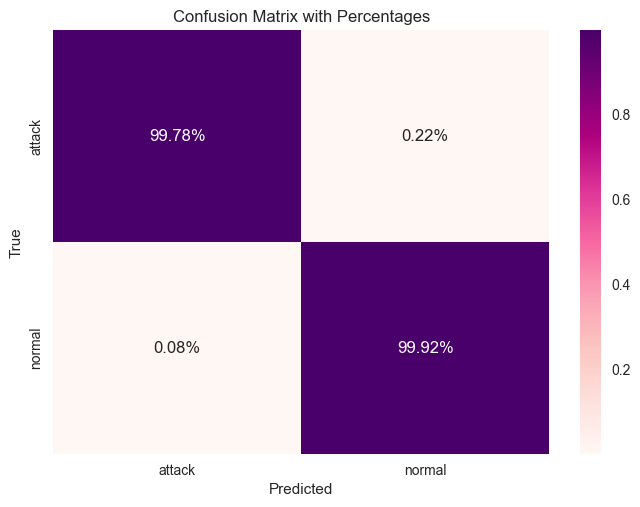

In [45]:
# Normalized confusion matrix
cm1_normalized = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix with percentages as a heatmap
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm1_normalized.flatten()]
labels = np.asarray(group_percentages).reshape(2,2)
ax = sns.heatmap(cm1_normalized, annot=labels, cmap='RdPu', fmt='', xticklabels=le2.classes_, yticklabels=le2.classes_)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix with Percentages')

##### Phase 2

In [46]:
rf2 = RandomForestClassifier()

# Train the Random Forest classifier
y_train_pred = rf1.predict(X_train_encoded)
rf2.fit(X_train_encoded[y_train_pred == 0], y_train[y_train_pred == 0]['labels5'])

# Make predictions on the test data
y_pred2 = rf2.predict(X_test_encoded[y_pred1 == 0])
print("Phase 2 Classification Report:")
print(classification_report(y_test[y_pred1 == 0]['labels5'], y_pred2, target_names=le5.classes_, zero_division=0))

Phase 2 Classification Report:
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     13837
       Probe       1.00      1.00      1.00      3437
         R2L       0.99      1.00      0.99       293
         U2R       0.91      0.91      0.91        11
      normal       0.00      0.00      0.00        16

    accuracy                           1.00     17594
   macro avg       0.78      0.78      0.78     17594
weighted avg       1.00      1.00      1.00     17594



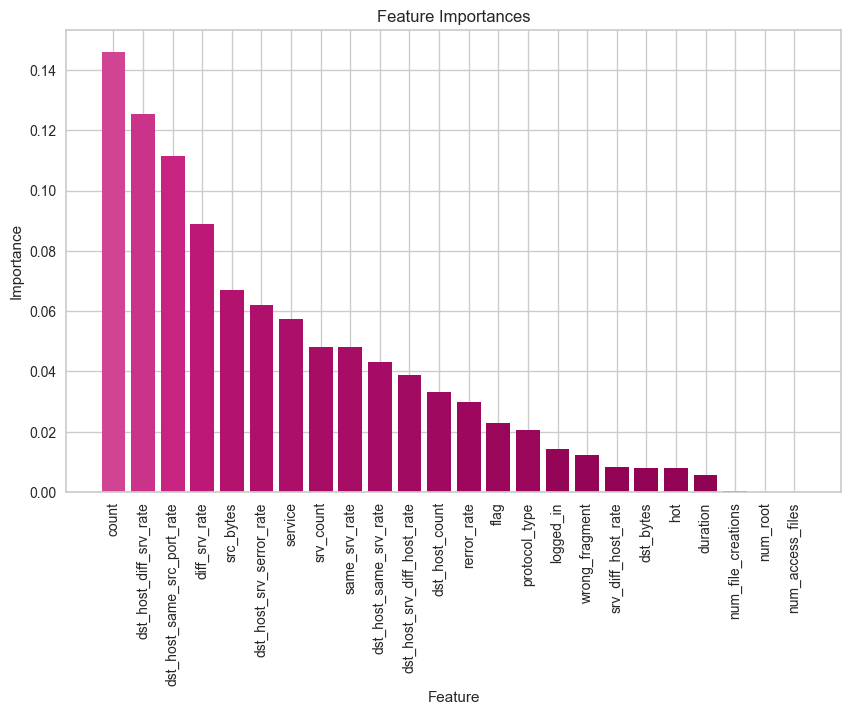

In [47]:
# Get feature importances
feature_importances = rf2.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
cmap = plt.get_cmap('PiYG')
plt.figure(figsize=(10, 6))
plt.bar(range(X_train_encoded[y_train_pred == 0].shape[1]), feature_importances[indices], align='center', color=cmap(feature_importances[indices]))
plt.xticks(range(X_train_encoded[y_train_pred == 0].shape[1]), X_train_encoded[y_train_pred == 0].columns[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

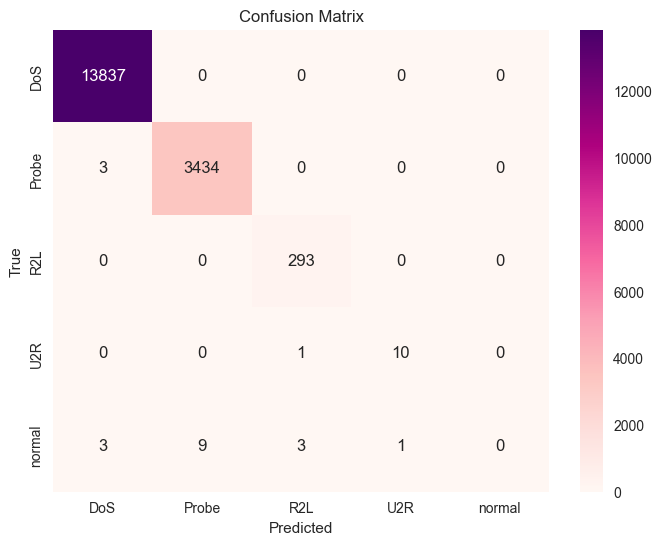

In [48]:
# Confusion matrix
cm2 = confusion_matrix(y_test[y_pred1 == 0]['labels5'], y_pred2)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, cmap='RdPu', fmt='g', xticklabels=le5.classes_, yticklabels=le5.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Text(0.5, 1.0, 'Confusion Matrix with Percentages')

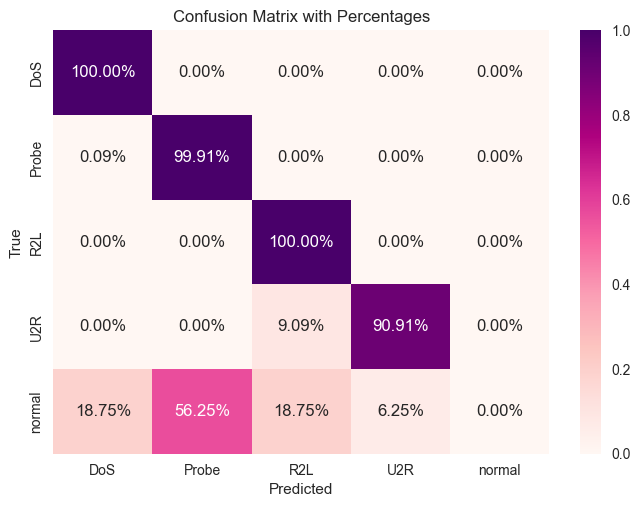

In [49]:
# Normalized confusion matrix
cm2_normalized = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix with percentages as a heatmap
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm2_normalized.flatten()]
labels = np.asarray(group_percentages).reshape(5,5)
ax = sns.heatmap(cm2_normalized, annot=labels, cmap='RdPu', fmt='', xticklabels=le5.classes_, yticklabels=le5.classes_)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix with Percentages')